In [307]:
import pandas as pd
import numpy as np
#import statsmodels.formula.api as smf
import statsmodels.api as sm
#from statsmodels.formula.api import ols
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings("ignore")
import xgboost as xgb

OnlineNewsPopularity = pd.read_csv("OnlineNewsPopularity.csv")

In [308]:
from sklearn.model_selection import cross_val_score,train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    OnlineNewsPopularity.drop([' shares', 'url'], axis = 1),
    OnlineNewsPopularity[' shares'],
    test_size = 0.2,
    random_state = 42)

In [309]:
train = pd.concat([X_train, y_train], axis = 1)
X = pd.concat([X_train, X_test], axis = 0)
y = pd.concat([y_train, y_test], axis = 0)
train.rename(columns = {' share': 'share'}, inplace = True)

# XGBoost base model:

In [3]:
#RMSE based on the parameter values that provide a cross validation R-squared close to the optimal one
model = xgb.XGBRegressor(random_state=1,max_depth=6,n_estimators=1000,
                                         learning_rate = 0.01,reg_lambda=0.01).fit(X_train, y_train)

In [4]:
from sklearn.metrics import mean_squared_error
print("XGBoost RMSE = ",np.sqrt(mean_squared_error(model.predict(X_test),y_test)))

XGBoost RMSE =  11765.139174723256


# Models from 303-2:

In [57]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import r2_score

In [61]:
#Taking the log transform of house_price as house prices have a right-skewed distribution
y = np.log(train[' shares'])

In [62]:
#Standardizing predictors so that each of them have zero mean and unit variance
#Defining a scaler object
scaler = StandardScaler()

#The scaler object will contain the mean and variance of each column (predictor) of X. 
#These values will be useful to scale test data based on the same mean and variance as obtained on train data
scaler.fit(X_train)

#Using the scaler object (or the values of mean and variance stored in it) to standardize X (or train data)
Xstd = scaler.transform(X_train)

## (a) Ridge

In [63]:
#The tuning parameter lambda is referred as alpha in sklearn

#Creating a range of values of the tuning parameter to visualize the ridge regression coefficients
#for different values of the tuning parameter
alphas = 10**np.linspace(10,-2,200)*0.5

In [64]:
#Finding the ridge regression coefficients for increasing values of the tuning parameter
coefs = []
for a in alphas:        
    ridge = Ridge(alpha = a)
    ridge.fit(Xstd, y)
    coefs.append(ridge.coef_)

Text(0, 0.5, 'Standardized coefficient')

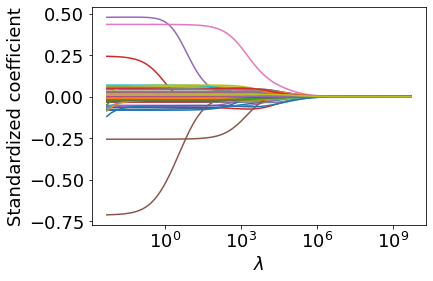

In [67]:
#Visualizing the shrinkage in ridge regression coefficients with increasing values of the tuning parameter lambda
plt.xlabel('xlabel', fontsize=18)
plt.ylabel('ylabel', fontsize=18)
plt.plot(alphas, coefs)
plt.xscale('log')
plt.xlabel('$\lambda$')
plt.ylabel('Standardized coefficient')

In [68]:
#Let us use cross validation to find the optimal value of the tuning parameter - lambda
#For the optimal lambda, the cross validation error will be the least

#Note that we are reducing the range of alpha so as to better visualize the minimum
alphas = 10**np.linspace(1.5,-3,200)*0.5
ridgecv = RidgeCV(alphas = alphas,store_cv_values=True)
ridgecv.fit(Xstd, y)

#Optimal value of the tuning parameter - lambda
ridgecv.alpha_

15.811388300841896

Text(0, 0.5, 'Cross-validation error')

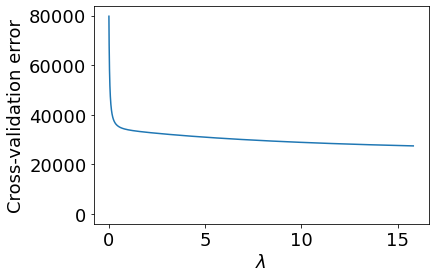

In [72]:
#Visualizing the LOOCV (leave one out cross validatation error vs lambda)
plt.xlabel('xlabel', fontsize=18)
plt.ylabel('ylabel', fontsize=18)
plt.plot(ridgecv.alphas,ridgecv.cv_values_.sum(axis=0))
plt.plot([ridgecv.alpha_,ridgecv.alpha_],[40,40.2],':')
plt.xlabel('$\lambda$')
plt.ylabel('Cross-validation error')

Text(0, 0.5, 'Standardized coefficient')

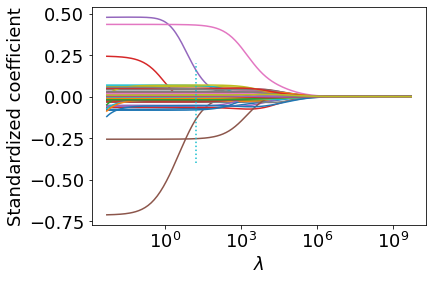

In [74]:
#Visualizing the shrinkage in ridge regression coefficients with increasing values of the tuning parameter lambda
alphas = 10**np.linspace(10,-2,200)*0.5
plt.xlabel('xlabel', fontsize=18)
plt.ylabel('ylabel', fontsize=18)
plt.plot(alphas, coefs)
plt.plot([ridgecv.alpha_,ridgecv.alpha_],[-0.4,0.2],':')
plt.xscale('log')
plt.xlabel('$\lambda$')
plt.ylabel('Standardized coefficient')

In [69]:
#Test dataset
#Standardizing test data
Xtest_std = scaler.transform(X_test)

In [70]:
#Using the developed ridge regression model to predict on test data
ridge = Ridge(alpha = ridgecv.alpha_)
ridge.fit(Xstd, y)
pred=ridge.predict(Xtest_std)

In [71]:
#RMSE on test data
np.sqrt(((np.exp(pred)-y_test)**2).mean())

11000.54448545831

## (b) Lasso

In [75]:
#Creating a range of values of the tuning parameter to visualize the lasso coefficients
#for different values of the tuning parameter
alphas = 10**np.linspace(10,-2,100)*0.1

In [76]:
#Finding the lasso coefficients for increasing values of the tuning parameter
lasso = Lasso(max_iter = 10000)
coefs = []

for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(Xstd, y)
    coefs.append(lasso.coef_)

Text(0, 0.5, 'Standardized coefficient')

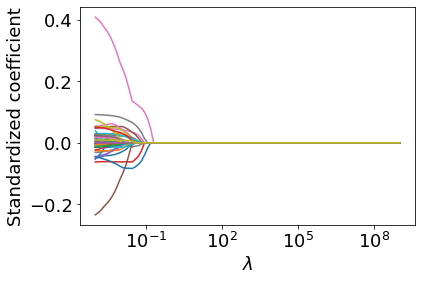

In [77]:
#Visualizing the shrinkage in lasso coefficients with increasing values of the tuning parameter lambda
plt.xlabel('xlabel', fontsize=18)
plt.ylabel('ylabel', fontsize=18)
plt.plot(alphas, coefs)
plt.xscale('log')
plt.xlabel('$\lambda$')
plt.ylabel('Standardized coefficient')

In [78]:
#Let us use cross validation to find the optimal value of the tuning parameter - lambda
#For the optimal lambda, the cross validation error will be the least

#Note that we are reducing the range of alpha so as to better visualize the minimum
alphas = 10**np.linspace(-1,-5,200)*0.5
lassocv = LassoCV(alphas = alphas, cv = 10, max_iter = 100000)
lassocv.fit(Xstd, y)

#Optimal value of the tuning parameter - lamda
lassocv.alpha_

0.0005879247770260784

Text(0, 0.5, 'Cross-validation error')

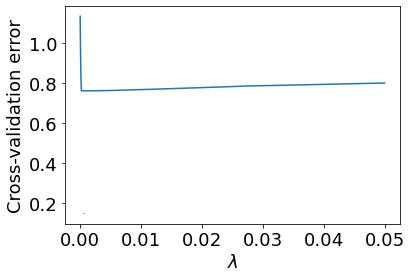

In [79]:
#Visualizing the LOOCV (leave one out cross validatation error vs lambda)
plt.xlabel('xlabel', fontsize=18)
plt.ylabel('ylabel', fontsize=18)
plt.plot(lassocv.alphas_,lassocv.mse_path_.mean(axis=1))
plt.plot([lassocv.alpha_,lassocv.alpha_],[0.145,0.151],':')
plt.xlabel('$\lambda$')
plt.ylabel('Cross-validation error')

In [80]:
#Using the developed lasso model to predict on test data
lasso = Lasso(alpha = lassocv.alpha_)
lasso.fit(Xstd, y)
pred=lasso.predict(Xtest_std)

In [82]:
#RMSE on test data
np.sqrt(((np.exp(pred)-y_test)**2).mean())

11001.737167062633